# Multi-channel, bidirectional optogenetics

Cleo supports the simultaneous use of multiple {class}`~cleo.opto.Light` devices, multiple channels per device, and multiple opsins per neuron group.
Here' we'll see how to use all these features.

In [10]:
# boilerplate
%load_ext autoreload
%autoreload 2
from brian2 import *
import matplotlib.pyplot as plt

import cleo
from cleo import *
import cleo.opto

cleo.utilities.style_plots_for_docs()

# numpy faster than cython for lightweight example
prefs.codegen.target = 'numpy'
# for reproducibility
np.random.seed(1866)

# colors
c = {
    'light': '#df87e1',
    'main': '#C500CC',
    'dark': '#8000B4',
    'exc': '#d6755e',
    'inh': '#056eee',
    'accent': '#36827F',
    '473nm': '#72b5f2',
    '590nm': (1, .875, 0),
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Network setup
We'll use excitatory and inhibitory populations of [exponential integrate-and-fire neurons](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html).

In [11]:
n_e = 500
n_i = n_e // 4
def eif(n, name):
    ng = NeuronGroup(
        n,
        """
        dv/dt = (
            -(v - E_L)
            + Delta_T*exp((v-theta)/Delta_T)
            + Rm*(I1 + I2 + I_bg)
        ) / tau_m + sigma*sqrt(2/tau_m)*xi: volt
        I1 : amp
        I2 : amp
        """,
        threshold="v>30*mV",
        reset="v=-55*mV",
        namespace={
            "tau_m": 20 * ms,
            "Rm": 500 * Mohm,
            "theta": -50 * mV,
            "Delta_T": 2 * mV,
            "E_L": -70*mV,
            "sigma": 5 * mV,
            "I_bg": 0 * namp,
        },
        name=name,
    )
    ng.v = np.random.uniform(-70, -50, n) * mV
    return ng

exc = eif(n_e, "neurons")
I_bg = 25 * pamp
exc.namespace["I_bg"] = I_bg
# inh.namespace["I_bg"] = I_bg
# inh = eif(n_i, "inh")
W = 1 * mV
p_S = 0.3
# S_ei = Synapses(exc, inh, on_pre="v_post+=W/sqrt(N_incoming)")
# S_ei.connect(p=p_S)
# S_ie = Synapses(inh, exc, on_pre="v_post-=W/sqrt(N_incoming)")
# S_ie.connect(p=p_S)
# S_ii = Synapses(inh, inh, on_pre="v_post-=W/sqrt(N_incoming)")
# S_ii.connect(p=p_S)
n_neighbors = 20
S_ee = Synapses(exc, model='w: 1', on_pre="v_post+=W*w/sqrt(N)")
S_ee.connect(condition='abs(i-j)<=n_neighbors and i!=j')
S_ee.w = np.exp(np.random.randn(int(S_ee.N - 0)))

mon_e = SpikeMonitor(exc)
# mon_i = SpikeMonitor(inh)

# net = Network(exc, inh, S_ei, S_ie, S_ee, mon_e, mon_i)
net = Network(exc, S_ee, mon_e)
sim = cleo.CLSimulator(net)

In [12]:
# net.run(200*ms)

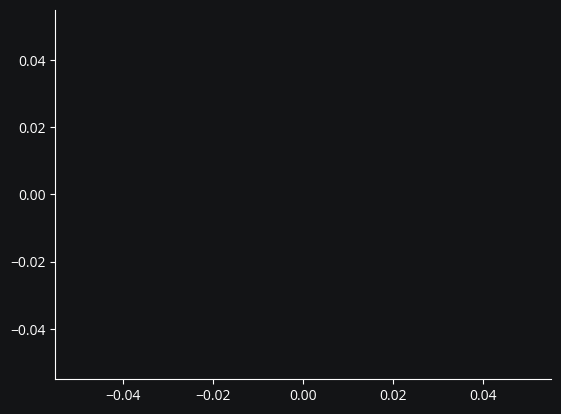

In [13]:
plt.plot(mon_e.t/ms, mon_e.i, '.', color=c['main'], label='exc')
# plt.plot(mon_i.t/ms, mon_i.i + n_e, '.', color=c['inh'], label='inh')

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

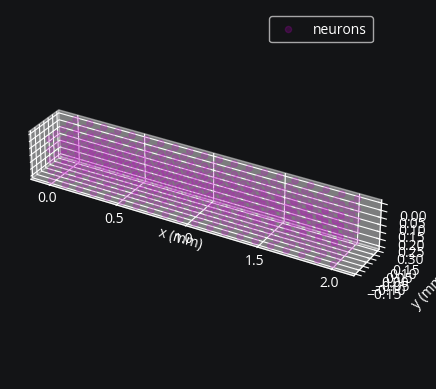

In [14]:
from cleo.coords import assign_coords_grid_rect_prism
xmax_mm = 2
assign_coords_grid_rect_prism(exc, xlim=(0, xmax_mm), ylim=(-.15, .15), zlim=(0, .3), shape=(20, 5, 5))
cleo.viz.plot(exc, colors=[c['main']])

## Injecting a multi-channel `Light`

A {class}`~cleo.opto.Light` device can have multiple channels; all the user needs is to specify the coordinates (and optionally direction) of each light source (channel).
A {class}`~cleo.opto.LightModel` (e.g., that of an optical fiber) defines how light propagates from each source.

Here we inject 590 nm light for activating Vf-Chrimson.
Lacking a more rigorous quantification, we assume absorption and scattering coefficients of 590 nm light in the brain are roughly 0.8 times that of 470 nm light (see [Jacques 2013](https://iopscience.iop.org/article/10.1088/0031-9155/58/11/R37/meta) for some justification).

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: xlabel='x (mm)', ylabel='y (mm)', zlabel='z (mm)'>)

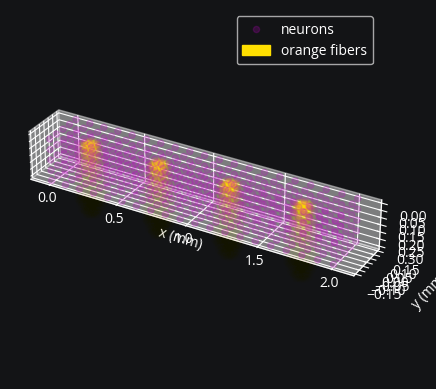

In [15]:
from cleo.opto import Light, FiberModel, VfChrimson_4S

n_fibers = 4
coords = np.zeros((n_fibers, 3))
end_space = 1 / (2 * n_fibers)
coords[:, 0] = np.linspace(end_space, 1 - end_space, n_fibers) * xmax_mm
coords[:, 1] = -0.075
orange_fibers = Light(
    name='orange fibers',
    coords=coords * mm,
    light_model=FiberModel(
        R0=50 * umeter, wavelength=590 * nmeter, K=0.125 * 0.8 / mm, S=7.37 * 0.8 / mm
    ),
)
sim.inject(orange_fibers, exc)
# vfc = VfChrimson_4S()
# sim.inject(vfc, exc, Iopto_var_name="I1")
cleo.viz.plot(exc, colors=[c["main"]], sim=sim)

## Bidirectional control via a second opsin
Here we will demonstrate increasing and decreasing activity in the same experiment by injecting an inhibitory opsin with a minimally overlapping activation spectrum.
Alternatively, we could achieve bidirectional control with excitatory opsins on excitatory and inhibitory neurons.

We will use the anion channel GtACR2 which is maximally activated by 470 nm light.

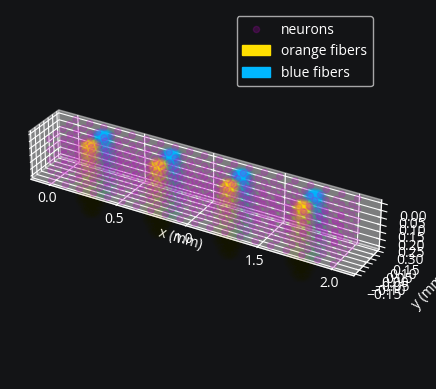

In [16]:
coords[:, 1] = 0.075
blue_fibers = Light(
    name="blue fibers",
    coords=coords * mm,
    light_model=cleo.opto.fiber473nm(R0=50 * umeter),
)
sim.inject(blue_fibers, exc)
gtacr2 = cleo.opto.GtACR2_4S()
# gtacr2 = cleo.opto.ChR2_B4S()
sim.inject(gtacr2, exc, Iopto_var_name="I2")
cleo.viz.plot(exc, colors=[c["main"]], sim=sim)
gmon = StateMonitor(exc, 'I2', record=range(50))
sim.network.add(gmon)

In [20]:
cleo.opto.GtACR2_4S().params
from attrs import fields_dict
fields_dict(cleo.opto.GtACR2_4S)['Gd1']

Attribute(name='Gd1', default=17. * hertz, validator=None, repr=True, eq=True, eq_key=None, order=True, order_key=None, hash=None, init=True, metadata=mappingproxy({}), type=<class 'brian2.units.fundamentalunits.Quantity'>, converter=None, kw_only=False, inherited=False, on_setattr=None)

## Open-loop stimulation
We will now design a stimulus pattern to demonstrate bidirectional control segregated by channel.

In [9]:
from cleo.ioproc import LatencyIOProcessor

class OpenLoopOpto(LatencyIOProcessor):
    def __init__(self):
        super().__init__(sample_period_ms=1)

    # since this is open-loop, we don't use state_dict
    def process(self, state_dict, time_ms):
        amplitude_mW_mm2 = 1
        time_offsets = np.array([0, -20, -40, -60])
        t = time_ms + time_offsets
        orange = 0#((t >= 20) & (t < 60)) * amplitude_mW_mm2
        blue = ((t >= 40) & (t < 80)) * amplitude_mW_mm2
        
        # return output dict and time
        return ({"orange fibers": orange, "blue fibers": blue}, time_ms)

sim.set_io_processor(OpenLoopOpto())

CLSimulator(io_processor=<__main__.OpenLoopOpto object at 0x7fa4cc432b90>, devices={Light(brian_objects=set(), sim=..., name='blue fibers', value=array([0., 0., 0., 0.]), save_history=True, light_model=FiberModel(R0=50. * umetre, NAfib=0.37, wavelength=0.473 * umetre, K=125. * metre ** -1, S=7370. * metre ** -1, ntis=1.36), coords=array([[ 250.,   75.,    0.],
       [ 750.,   75.,    0.],
       [1250.,   75.,    0.],
       [1750.,   75.,    0.]]) * umetre, direction=array([0., 0., 1.]), max_Irr0_mW_per_mm2=None, max_Irr0_mW_per_mm2_viz=None, default_value=array([0., 0., 0., 0.])), Light(brian_objects=set(), sim=..., name='orange fibers', value=array([0., 0., 0., 0.]), save_history=True, light_model=FiberModel(R0=50. * umetre, NAfib=0.37, wavelength=0.59 * umetre, K=100. * metre ** -1, S=5896. * metre ** -1, ntis=1.36), coords=array([[ 250.,  -75.,    0.],
       [ 750.,  -75.,    0.],
       [1250.,  -75.,    0.],
       [1750.,  -75.,    0.]]) * umetre, direction=array([0., 0., 1.]

### Run simulation and plot results

In [10]:
sim.reset()
sim.run(160*ms)

INFO       No numerical integration method specified for group 'neurons', using method 'euler' (took 0.04s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]


INFO       No numerical integration method specified for group 'opto_syn_GtACR2_4S_neurons', using method 'euler' (took 0.03s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]


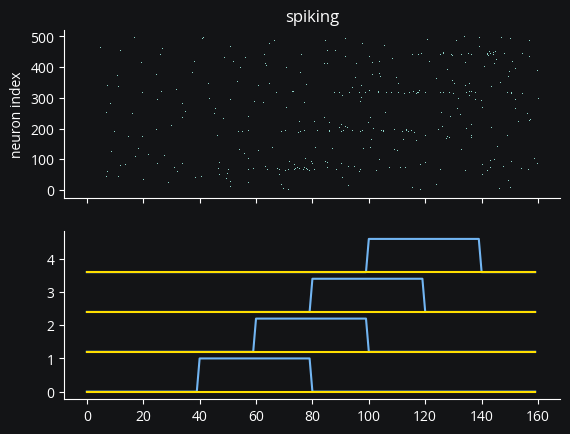

In [11]:

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(mon_e.t / ms, mon_e.i[:], ',')
ax1.set(ylabel='neuron index', title='spiking')
# ax2.plot(t_sim, stimulus(t_sim))
# ax2.set(ylabel=r'$Irr_0$ (mm/mW$^2$)', title='optogenetic stimulus', xlabel='time (ms)');
ax2.plot(blue_fibers.t_ms, blue_fibers.values + np.arange(n_fibers)*1.2, c=c['473nm'])
ax2.plot(orange_fibers.t_ms, orange_fibers.values + np.arange(n_fibers)*1.2, c=c['590nm'])

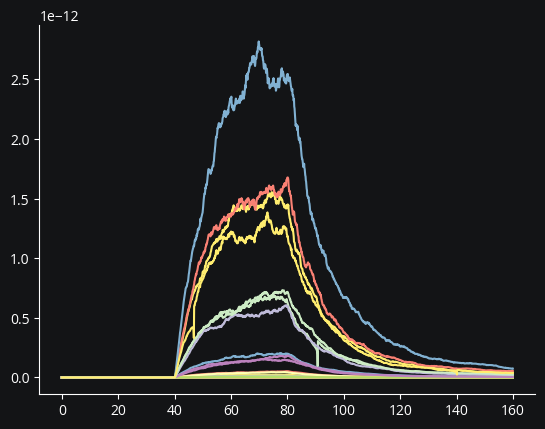

In [12]:
plt.plot(gmon.t/ms, gmon.I2.T);

In [13]:
gtacr2.g0

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

3.2 * nsiemens

In [ ]:
opsin.opto_syns[ng.name].equations

NameError: name 'opsin' is not defined

## Conclusion
We can see clearly that firing rate correlates with light intensity as expected.

As a recap, in this tutorial we've seen how to:
* configure an `OptogeneticIntervention`,
* inject it into the simulation,
* and control its light intensity in an open-loop fashion.

## Appendix: alternative opsin and neuron models

Because it would be a pain and an obstacle to reproducibility to have to replace all pre-existing simple neuron models with more sophisticated ones with proper voltage ranges and units, we provide an approximation that is much more flexible, requiring only a current term, of any unit, in the target neurons. 

The Markov models of opsin dynamics we've used so far produce a rise, peak, and fall to a steady-state plateau current when subjected to sustained light. Since they are conductance-based, the current also varies with membrane voltage, including during spikes.
The `ProportionalCurrentModel`, on the other hand, simply delivers current proportional to light intensity. 
This should be adequate for a wide range of use cases where the exact opsin current dynamics on short timescales don't matter so much and a sort of average current-light relationship will suffice.

Speaking of realistic membrane voltages, does the Markov model's voltage-dependent current render it unsuitable for the most basic leaky integrate-and-fire (LIF) neuron model? LIF neurons reset on reaching their rheobase threshold, staying perpetually in a subthreshold region producing exaggerated opsin currents. How much does this affect the output? We will explore this question by comparing a variety of opsin/neuron model combinations.

First, we introduce exponential integrate-and-fire neurons, which maintain simplicity while modeling an upward membrane potential swing during a spike. For more info, see the [related section in the Neuronal Dynamics online textbook](https://neuronaldynamics.epfl.ch/online/Ch5.S2.html) and their [example parameters table](https://neuronaldynamics.epfl.ch/online/Ch6.S2.html#:~:text=Table%C2%A06.1%3A%20Exemplar%20parameters).


In [ ]:
neuron_params = {
    "tau_m": 20 * ms,
    "Rm": 500 * Mohm,
    "theta": -50 * mV,
    "Delta_T": 2 * mV,
    "E_L": -70*mV,
}

def prep_ng(ng, neuron_type, markov_opsin):
    ng.v = neuron_params['E_L']
    assign_coords_rand_rect_prism(ng, xlim=(0, 0), ylim=(0, 0), zlim=(0, 0))
    state_mon = StateMonitor(ng,("Iopto", "v"), record=True)
    spike_mon = SpikeMonitor(ng)
    return neuron_type, ng, state_mon, spike_mon, markov_opsin

experiments = []

eif = NeuronGroup(
    1,
    """
    dv/dt = (-(v - E_L) + Delta_T*exp((v-theta)/Delta_T) + Rm*Iopto) / tau_m : volt
    Iopto : amp
    """,
    threshold="v > -10*mV",
    reset="v = E_L - 0*mV",
    namespace=neuron_params,
)

experiments.append(prep_ng(eif, 'EIF', True))

### Configure LIF models
Here we define LIF neurons with biological parameters for the sake of comparison, but the `ProportionalCurrentModel` is compatible with models of any voltage range and units, so long as it has an `Iopto` term.

In [ ]:
def prep_lif(markov_opsin):
    ng = NeuronGroup(
        1,
        """dv/dt = (-(v - E_L) + Rm*Iopto) / tau_m : volt
        Iopto : amp""",
        threshold="v > theta + 4*mV",
        reset="v = E_L - 0*mV",
        namespace=neuron_params,
    )
    return prep_ng(ng, "LIF", markov_opsin)

experiments.append(prep_lif(True))
experiments.append(prep_lif(False))

### Comparing to more realistic models
To see how well simplified neuron and opsin models do, we'll also compare to the more complex [AdEx neuron](http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model#:~:text=The%20Adaptive%20exponential%20integrate-and-fire%20model%2C%20also%20called%20AdEx%2C,coupled%20to%20a%20second%20equation%20which%20describes%20adaptation.) (with ["tonic" firing pattern parameters](https://neuronaldynamics.epfl.ch/online/Ch6.S2.html)) and a Hodgkin-Huxley model (code from [Neuronal Dynamics](https://neuronaldynamics-exercises.readthedocs.io/en/latest/_modules/neurodynex3/hodgkin_huxley/HH.html#:~:text=def%20simulate_HH_neuron)).

In [ ]:
adex = NeuronGroup(
    1,
    """dv/dt = (-(v - E_L) + 2*mV*exp((v-theta)/Delta_T) + Rm*(Iopto-w)) / tau_m : volt
    dw/dt = (0*nsiemens*(v-E_L) - w) / (100*ms) : amp
    Iopto : amp""",
    threshold="v>=-10*mV",
    reset="v=-55*mV; w+=5*pamp",
    namespace=neuron_params,
)
experiments.append(prep_ng(adex, "AdEx", True))

# Parameters
# Cm = 1*ufarad*cm**-2 * area
Cm = neuron_params["tau_m"] / neuron_params["Rm"]
# area = 5000*umetre**2
area = Cm / (1*ufarad*cm**-2)
gl = 0.3*msiemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 40*msiemens*cm**-2 * area
g_kd = 35*msiemens*cm**-2 * area
VT = -63*mV

# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + Iopto)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
Iopto : amp
''')
# Threshold and refractoriness are only used for spike counting
hh = NeuronGroup(1, eqs,
                 threshold='v > -40*mV',
                 reset='',
                 method='exponential_euler')

experiments.append(prep_ng(hh, "HH", True))

### Opsin configuration
Note that the only parameter we need to set for the simple opsin model is the gain on light intensity, `I_per_Irr`.
This term defines what the neuron receives for every 1 mW/mm2 of light intensity.
Here that term is defined in amperes, but it could have been unitless for a simpler model.

The gain is tuned somewhat by hand (in relation to the membrane resistance and the 20 mV gap between rest and threshold potential) to achieve similar outputs to the Markov model.

In [ ]:
light = Light(light_model=fiber473nm())
simple_opsin = ProportionalCurrentOpsin(
    name="simple_opsin",
    # handpicked gain to make firing rate roughly comparable to EIF
    I_per_Irr=140/neuron_params['Rm']*20*mV,
)
markov_opsin = ChR2_4S(name="markov_opsin")

### Simulation

And we set up the simulator:

In [ ]:
net = Network()
sim = CLSimulator(net)
for ng_type, ng, state_mon, spike_mon, use_markov_opsin in experiments:
    net.add(ng, state_mon, spike_mon)
    sim.inject(light, ng)
    if use_markov_opsin:
        sim.inject(markov_opsin, ng)
    else:
        sim.inject(simple_opsin, ng)

We'll now run the simulation with light pulses of increasing amplitudes to observe the effect on the current.

In [ ]:
# hand-picked range of amplitudes to show 0 to moderate firing rates
for Irr0_mW_per_mm2 in np.linspace(0.015, 0.05, 5):
    light.update(Irr0_mW_per_mm2)
    sim.run(60 * ms)
    light.update(0)
    sim.run(60 * ms)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.01s, trying other methods took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'exact' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'exact' (took 0.02s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
WARNING    'n' is an internal variable of group 'neurongroup_5', but also exists in the run namespace with the value 10. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
INFO       No numerical integration method specified for group 'opto_syn_markov_opsin_neurong

### Results

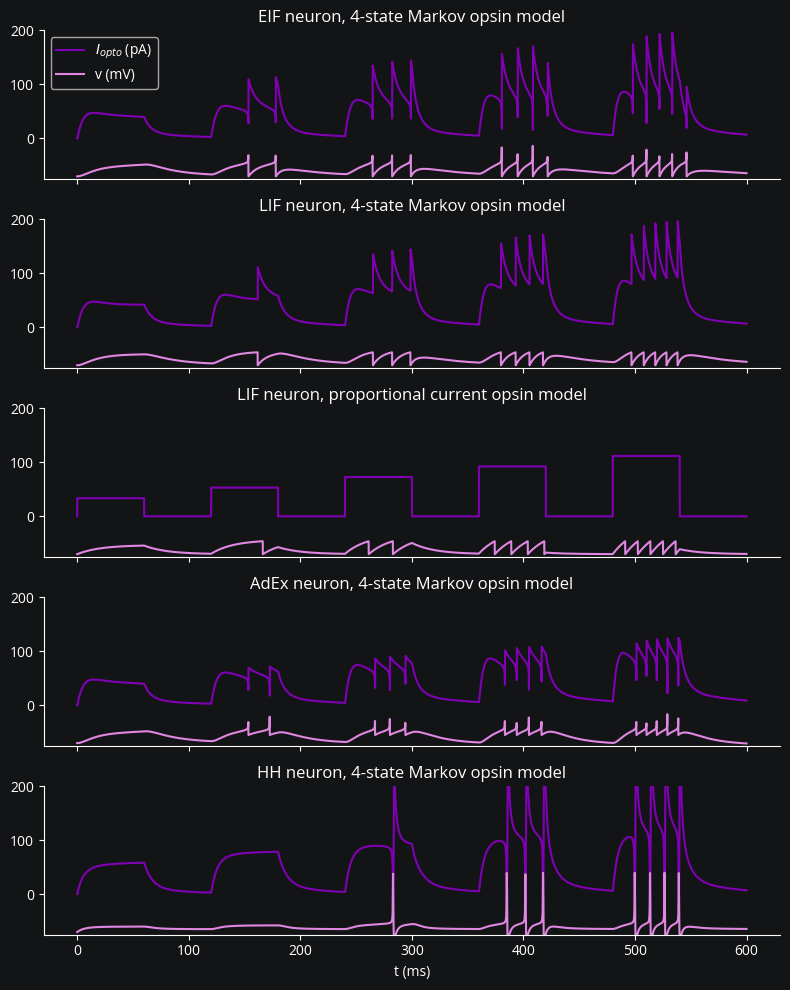

In [ ]:
c1 = '#8000b4'
c2 = '#df87e1'

fig, axs = plt.subplots(
    len(experiments), 1, figsize=(8, 2*len(experiments)), sharex=True
)

for ax, (ng_type, _, state_mon, spike_mon, markov_opsin) in zip(axs, experiments):
    ax.plot(state_mon.t / ms, state_mon.Iopto[0] / pamp, c=c1, label="$I_{opto}$ (pA)")
    ax.plot(state_mon.t / ms, state_mon.v[0] / mV, c=c2, label="v (mV)")
    opsin_name = "4-state Markov" if markov_opsin else "proportional current"
    ax.set(title=f"{ng_type} neuron, {opsin_name} opsin model")

axs[-1].set_xlabel('t (ms)')
axs[0].legend();

max_ylim = max([ax.get_ylim()[1] for ax in axs])
for ax in axs:
    ax.set_ylim([-75, 200])

fig.tight_layout()

Qualitatively we can see that the proportional current model doesn't capture the rise, peak, plateau, and fall dynamics that a Markov model can produce, but is a reasonable approximation if all you need is a roughly linear light intensity-firing rate relationship. We also see that a variety of neuron/opsin model combinations all produce similar firing responses to light.